In [1]:
import csv
import tqdm
import click
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 50
batch_size = 64
learning_rate = 1e-3

lookback = 20
context_frames = lookback
sequence_length = lookback

context_epochs = 30
context_batch_size = 1
context_learning_rate = 1e-3

test_train_split = 0.9  # precentage of train data from total
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available


In [2]:

class DataFormatter():
    def __init__(self):
        print("initialised data formatter")

    def get_datasets(self):
        #=======================================================================================================================
        # load dataset
        tactile_data = np.load('/home/user/Robotics/slip_detection_franka/python scripts/dataFiles/xela_numeric.npy')

        robot_data = np.load('/home/user/Robotics/slip_detection_franka/python scripts/dataFiles/robot_data_26993.npy')

        Y = pd.read_csv('/home/user/Robotics/slip_detection_franka/python scripts/dataFiles/labels_data_26993.csv')
        Y = Y['slip']

        print(tactile_data.shape)
        print(Y.shape)
        #========================================================================================================================
        # function for making suitable input for lstm
        def temporalize(X, y, lookback):
            output_X = []
            output_y = []
            for i in range(len(X)-lookback-1):
                t = []
                for j in range(1,lookback+1):
                    # Gather past records upto the lookback period
                    t.append(X[[(i+j+1)], :])
                output_X.append(t)
                output_y.append(y[i+lookback+1])
            return output_X, output_y

        # remove nan values from data samples
        indexes_to_delete = []
        for index, values in enumerate(robot_data):
            if np.isnan(values).any():
                indexes_to_delete.append(index)
        tactile_data = np.delete(tactile_data, indexes_to_delete, 0)
        robot_data = np.delete(robot_data, indexes_to_delete, 0)

        # Temporalize the data
        X_tactile, y = temporalize(X = tactile_data[:-lookback], y = Y, lookback = lookback)
        X_robot_trajectory, zq = temporalize(X = robot_data[:], y = Y, lookback = lookback*2)
        label, rr = temporalize(X = tactile_data[lookback:], y = Y, lookback = lookback)

        #split data into train, validation and test set
        X_tactile_train, X_tactile_test, y_train, y_test = train_test_split(np.array(X_tactile), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED, shuffle=False)
        label_train, label_test, rr_train, rr_test = train_test_split(np.array(label), np.array(rr), test_size=DATA_SPLIT_PCT, random_state=SEED, shuffle=False)
        X_robot_trajectory_train, X_robot_trajectory_test, zq_train, zq_test = train_test_split(np.array(X_robot_trajectory), np.array(zq), test_size=DATA_SPLIT_PCT, random_state=SEED, shuffle=False)

        X_tactile_train, X_tactile_valid, y_train, y_valid = train_test_split(X_tactile_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
        X_robot_trajectory_train, X_robot_trajectory_valid, zq_train, zq_valid = train_test_split(X_robot_trajectory_train, zq_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
        label_train, label_valid, rr_train, rr_valid = train_test_split(np.array(label_train), np.array(rr_train), test_size=DATA_SPLIT_PCT, random_state=SEED)


        print('tactile train set input data shape:', X_tactile_train.shape)
        print('robot train set input data shape:', X_robot_trajectory_train.shape)
        #=============================================================================================================================
        #Reshaping the data
        #The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.
        n_features_tactile = 96
        n_features_robot = 4

        X_tactile_train = X_tactile_train.reshape(X_tactile_train.shape[0], lookback, n_features_tactile)
        X_tactile_valid = X_tactile_valid.reshape(X_tactile_valid.shape[0], lookback, n_features_tactile)
        X_tactile_test = X_tactile_test.reshape(X_tactile_test.shape[0], lookback, n_features_tactile)

        X_robot_trajectory_train = X_robot_trajectory_train.reshape(X_robot_trajectory_train.shape[0], lookback*2, n_features_robot)
        X_robot_trajectory_valid = X_robot_trajectory_valid.reshape(X_robot_trajectory_valid.shape[0], lookback*2, n_features_robot)
        X_robot_trajectory_test = X_robot_trajectory_test.reshape(X_robot_trajectory_test.shape[0], lookback*2, n_features_robot)

        label_train = label_train.reshape(label_train.shape[0], lookback, n_features_tactile)
        label_valid = label_valid.reshape(label_valid.shape[0], lookback, n_features_tactile)
        label_test = label_test.reshape(label_test.shape[0], lookback, n_features_tactile)
        #=============================================================================================================================
        #Standardize the data
        #It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

        def flatten(X):
            '''
            Flatten a 3D array.
            Input
            X            A 3D array for lstm, where the array is sample x timesteps x features.
            Output
            flattened_X  A 2D array, sample x features.
            '''
            flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
            for i in range(X.shape[0]):
                flattened_X[i] = X[i, (X.shape[1]-1), :]
            return(flattened_X)


        def scale(X, scaler):
            '''
            Scale 3D array.
            Inputs
            X            A 3D array for lstm, where the array is sample x timesteps x features.
            scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize   
            Output
            X            Scaled 3D array.
            '''
            for i in range(X.shape[0]):
                X[i, :, :] = scaler.transform(X[i, :, :])
                
            return X

        # Initialize a scaler using the training data.
        scaler_test_tactiles  = np.concatenate((np.asarray(flatten(X_tactile_train)), np.asarray(flatten(X_tactile_valid)),
                                                np.asarray(flatten(X_tactile_test)), np.asarray(flatten(label_train)), 
                                                np.asarray(flatten(label_valid)), np.asarray(flatten(label_test))), axis=0).tolist()
        scaler_test_robot  = np.concatenate((np.asarray(flatten(X_robot_trajectory_train)),
                                                np.asarray(flatten(X_robot_trajectory_valid)),
                                                np.asarray(flatten(X_robot_trajectory_test))), axis=0).tolist()

        scaler_robot = MinMaxScaler().fit(scaler_test_robot)
        scaler_tactile = MinMaxScaler().fit(scaler_test_tactiles)

        X_tactile_train_scaled = scale(X_tactile_train, scaler_tactile)
        X_tactile_valid_scaled = scale(X_tactile_valid, scaler_tactile)
        X_tactile_test_scaled = scale(X_tactile_test, scaler_tactile)

        X_robot_trajectory_train_scaled = scale(X_robot_trajectory_train, scaler_robot)
        X_robot_trajectory_valid_scaled = scale(X_robot_trajectory_valid, scaler_robot)
        X_robot_trajectory_test_scaled = scale(X_robot_trajectory_test, scaler_robot)

        label_train_scaled = scale(label_train, scaler_tactile)
        label_valid_scaled = scale(label_valid, scaler_tactile)
        label_test_scaled = scale(label_test, scaler_tactile)

        dataset_train = FullDataSet(X_tactile_train_scaled, X_robot_trajectory_train_scaled, label_train_scaled)
        dataset_valid = FullDataSet(X_tactile_valid_scaled, X_robot_trajectory_valid_scaled, label_valid_scaled)
        dataset_test  = FullDataSet(X_tactile_test_scaled, X_robot_trajectory_test_scaled, label_test_scaled)

        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

        return train_loader, valid_loader, test_loader


class FullDataSet():
    def __init__(self, taxelset, actionset, stateset):
        self.samples = []
        for i in range(len(taxelset)):
            self.samples.append([taxelset[i], actionset[i], stateset[i]])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])
    
DF = DataFormatter()
train_loader, valid_loader, test_loader = DF.get_datasets()
print("done")

initialised data formatter
(26993, 96)
(26993,)
tactile train set input data shape: (17248, 20, 1, 96)
robot train set input data shape: (17248, 40, 1, 4)
done


In [3]:
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(96, 96).to(device)  # tactile
        self.lstm2 = nn.LSTM(4, 4).to(device)  # pos_vel
        self.fc1 = nn.Linear(96+4, 96)  # tactile + pos_vel
        self.lstm3 = nn.LSTM(96, 96).to(device)  # pos_vel

    def forward(self, tactiles, actions):
        outputs = []
        batch_size__ = tactiles.shape[1]
        hidden1 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))
        hidden2 = (torch.zeros(1,batch_size__,4).to(device), torch.zeros(1,batch_size__,4).to(device))
        hidden3 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))

        for index, sample_action in enumerate(actions.squeeze()):
            sample_action.to(device)
            if index >= lookback:
                out1, hidden1 = self.lstm1(out4, hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)
                outputs.append(out4.squeeze())
            else:
                sample_tactile = tactiles[index]
                sample_tactile.to(device)
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)

        return torch.stack(outputs)


In [ ]:
class FullModelContext(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(96, 96).to(device)  # tactile
        self.lstm2 = nn.LSTM(4, 4).to(device)  # pos_vel
        self.fc1 = nn.Linear(96+4, 96)  # tactile + pos_vel
        self.lstm3 = nn.LSTM(96, 96).to(device)  # pos_vel

    def forward(self, tactiles, actions):
        outputs = []
        batch_size__ = tactiles.shape[1]
        hidden1 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))
        hidden2 = (torch.zeros(1,batch_size__,4).to(device), torch.zeros(1,batch_size__,4).to(device))
        hidden3 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))

        for index, sample_action in enumerate(actions.squeeze()):
            sample_action.to(device)
            if index >= lookback:
                out1, hidden1 = self.lstm1(out4, hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)
                outputs.append(out4.squeeze())
            else:
                sample_tactile = tactiles[index]
                sample_tactile.to(device)
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)

        return torch.stack(outputs)


In [33]:
class FullModelScaleDownAndUp(nn.Module):
    def __init__(self):
        super(FullModelScaleDownAndUp, self).__init__()
        # scale down the tactile data to 4 dim
        self.lstm1 = nn.LSTM(96, 96).to(device)
        self.fc_tactile1 = nn.Linear(96, 48)
        self.lstm2 = nn.LSTM(48, 48).to(device)
        self.fc_tactile2 = nn.Linear(48, 24)
        self.lstm3 = nn.LSTM(24, 24).to(device)
        self.fc_tactile3 = nn.Linear(24, 12)
        self.lstm4 = nn.LSTM(12, 12).to(device)
        # concat with action data
        self.lstmAction1 = nn.LSTM(4, 4).to(device)  # pos_vel
        self.fc_action1 = nn.Linear(4, 12)
        self.lstmTactileAction1 = nn.LSTM(24, 24).to(device)
        # scale back up to 96
        self.fc1 = nn.Linear(24, 48)
        self.lstmTactileAction2 = nn.LSTM(48, 48).to(device)
        self.fc2 = nn.Linear(48, 96)
        self.lstmTactileAction3 = nn.LSTM(96, 96).to(device)

    def forward(self, tactiles, actions):
        outputs = []
        batch_size__ = tactiles.shape[1]
        hidden1 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))
        hidden2 = (torch.zeros(1,batch_size__,48).to(device), torch.zeros(1,batch_size__,48).to(device))
        hidden3 = (torch.zeros(1,batch_size__,24).to(device), torch.zeros(1,batch_size__,24).to(device))
        hidden4 = (torch.zeros(1,batch_size__,12).to(device), torch.zeros(1,batch_size__,12).to(device))
        hidden5 = (torch.zeros(1,batch_size__,4).to(device), torch.zeros(1,batch_size__,4).to(device))
        hidden6 = (torch.zeros(1,batch_size__,24).to(device), torch.zeros(1,batch_size__,24).to(device))
        hidden7 = (torch.zeros(1,batch_size__,48).to(device), torch.zeros(1,batch_size__,48).to(device))
        hidden8 = (torch.zeros(1,batch_size__,96).to(device), torch.zeros(1,batch_size__,96).to(device))

        for index, sample_action in enumerate(actions.squeeze()):
            sample_action.to(device)
            if index >= lookback:
                # scale tactiles down:
                out1, hidden1 = self.lstm1(out14, hidden1)
                out2 = self.fc_tactile1(out1.cpu().detach())
                out3, hidden2 = self.lstm2(out2.to(device), hidden2)
                out4 = self.fc_tactile2(out3.cpu().detach())
                out5, hidden3 = self.lstm3(out4.to(device), hidden3)
                out6 = self.fc_tactile3(out5.cpu().detach())
                out7, hidden4 = self.lstm4(out6.to(device), hidden4)
                # concat with action:
                out8, hidden5 = self.lstmAction1(sample_action.unsqueeze(0), hidden5)
                out9 = self.fc_action1(out8.cpu().detach())
                robot_and_tactile = torch.cat((out9.squeeze().to(device), out7.squeeze()), 1)  # concat tactiles and state/action
                out10, hidden6 = self.lstmTactileAction1(robot_and_tactile.unsqueeze(0).to(device), hidden6)
                # scale back up:
                out11 = self.fc1(out10.cpu().detach())
                out12, hidden7 = self.lstmTactileAction2(out11.to(device), hidden7)
                out13 = self.fc2(out12.cpu().detach())
                out14, hidden8 = self.lstmTactileAction3(out13.to(device), hidden8)
                outputs.append(out14.squeeze())
            else:
                # scale tactiles down:
                sample_tactile = tactiles[index]
                sample_tactile.to(device)
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2 = self.fc_tactile1(out1.cpu().detach())
                out3, hidden2 = self.lstm2(out2.to(device), hidden2)
                out4 = self.fc_tactile2(out3.cpu().detach())
                out5, hidden3 = self.lstm3(out4.to(device), hidden3)
                out6 = self.fc_tactile3(out5.cpu().detach())
                out7, hidden4 = self.lstm4(out6.to(device), hidden4)
                # concat with action:
                out8, hidden5 = self.lstmAction1(sample_action.unsqueeze(0), hidden5)
                out9 = self.fc_action1(out8.cpu().detach())
                robot_and_tactile = torch.cat((out9.squeeze().to(device), out7.squeeze()), 1)  # concat tactiles and state/action
                out10, hidden6 = self.lstmTactileAction1(robot_and_tactile.unsqueeze(0).to(device), hidden6)
                # scale back up:
                out11 = self.fc1(out10.cpu().detach())
                out12, hidden7 = self.lstmTactileAction2(out11.to(device), hidden7)
                out13 = self.fc2(out12.cpu().detach())
                out14, hidden8 = self.lstmTactileAction3(out13.to(device), hidden8)
        return torch.stack(outputs)


In [36]:
class ModelTrainer:
    def __init__(self, train_loader, valid_loader, test_loader):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        ### Train the LSTM chain:
        self.full_model = FullModelScaleDownAndUp() #FullModel()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)
        self.train_full_model()
        torch.save(self.full_model.state_dict(), "FullModelScaleDownAndUp_001.pt")
        print("finished and saved model")

    def train_full_model(self):
        early_stop_count = 0
        previous_validation_mean_loss = 1.0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0
            losses = 0.0
            for index, batch_features in enumerate(self.train_loader):
                # 2. Reshape data and send to device:
                tactile = batch_features[0].type(torch.FloatTensor).permute(1,0,2).to(device)
                action = batch_features[1].type(torch.FloatTensor).permute(1,0,2).to(device)
                label = batch_features[2].type(torch.FloatTensor).permute(1,0,2).to(device)

                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action)  # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.to(device), label)
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()

            validation_losses = 0.0
            validation_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_loader):
                    # 2. Reshape data and send to device:
                    tactile = batch_features[0].type(torch.FloatTensor).permute(1,0,2).to(device)
                    action = batch_features[1].type(torch.FloatTensor).permute(1,0,2).to(device)
                    label = batch_features[2].type(torch.FloatTensor).permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    validation_loss = self.criterion(tactile_predictions.to(device), label)
                    validation_losses += validation_loss.item()

            print("Validation mean loss: {:.4f}, ".format(validation_losses / len(self.valid_loader)))

            if previous_validation_mean_loss < validation_losses / len(self.valid_loader):
                early_stop_count +=1
                if early_stop_count == 3:
                    print("Early stopping")
                    break
            else:
                early_stop_count = 0
                previous_validation_mean_loss = validation_losses / len(self.valid_loader) 

MT = ModelTrainer(train_loader, valid_loader, test_loader)

epoch: 1, loss: 0.1133, mean loss: 0.0000, :   2%|▏         | 271/13500 [00:32<3:18:11,  1.11it/s]

Validation mean loss: 0.1142, 


epoch: 2, loss: 0.1100, mean loss: 0.2261, :   4%|▍         | 544/13500 [01:10<2:19:36,  1.55it/s]

Validation mean loss: 0.1141, 


epoch: 3, loss: 0.1139, mean loss: 0.0000, :   6%|▌         | 813/13500 [01:47<3:44:04,  1.06s/it]

Validation mean loss: 0.1139, 


epoch: 3, loss: 0.1103, mean loss: 0.1144, :   8%|▊         | 1082/13500 [02:19<18:58, 10.91it/s] 

Validation mean loss: 0.1143, 


epoch: 5, loss: 0.1230, mean loss: 0.2179, :  10%|█         | 1354/13500 [03:08<2:50:11,  1.19it/s]

Validation mean loss: 0.1141, 


epoch: 5, loss: 0.1129, mean loss: 0.1144, :   0%|          | 5/13500 [03:39<164:52:00, 43.98s/it] 

Validation mean loss: 0.1139, 
Early stopping
finished and saved model


In [38]:
model = MT.full_model

tactile_predictions = []
tactile_groundtruth = []
with torch.no_grad():
    for index__, batch_features in enumerate(test_loader):
        # 2. Reshape data and send to device:
        tactile = batch_features[0].type(torch.FloatTensor).permute(1,0,2).to(device)
        action = batch_features[1].type(torch.FloatTensor).permute(1,0,2).to(device)
        label = batch_features[2].type(torch.FloatTensor).permute(1,0,2).to(device)

        tactile_predictions.append(model.forward(tactiles=tactile, actions=action))  # Step 3. Run our forward pass.
        tactile_groundtruth.append(label)


In [39]:
# calculate tactile values for full sample:
time_step_to_test_t1 = -1    # [batch_set, 16, 10, 48]
predicted_data_t1 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(values)
        gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data.append(gt_values)


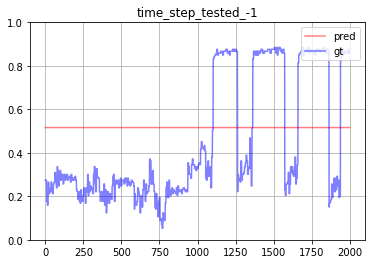

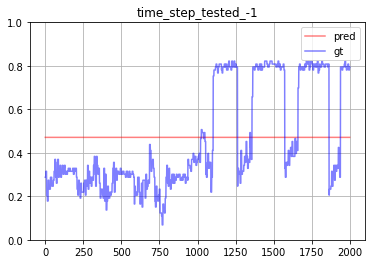

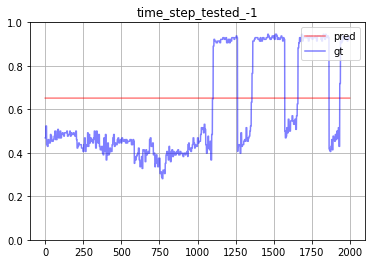

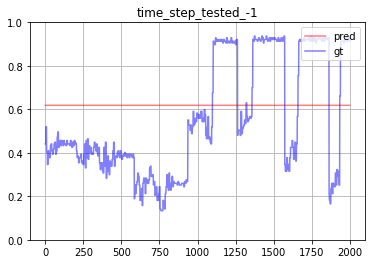

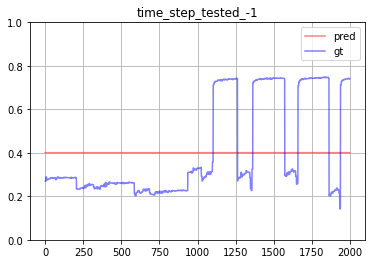

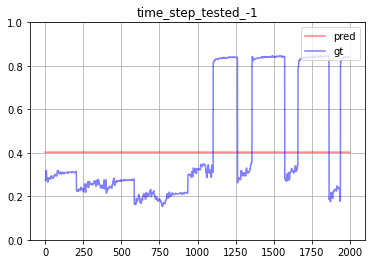

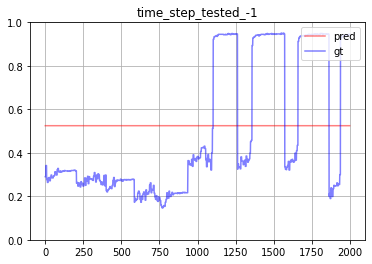

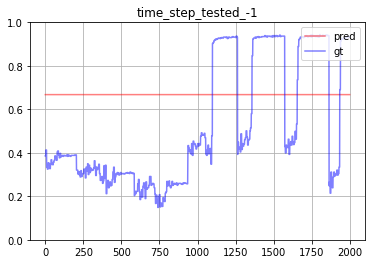

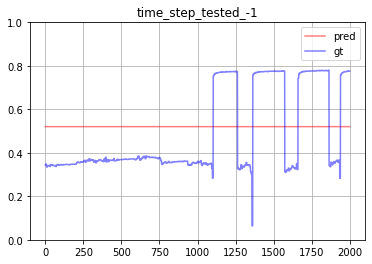

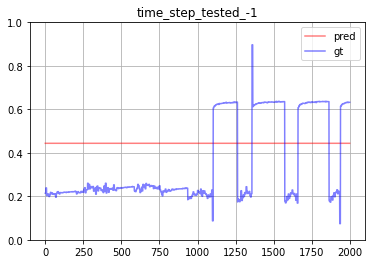

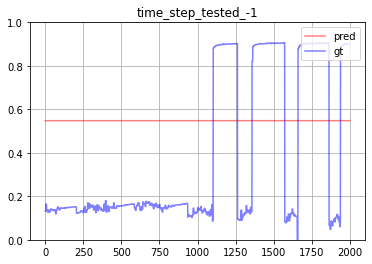

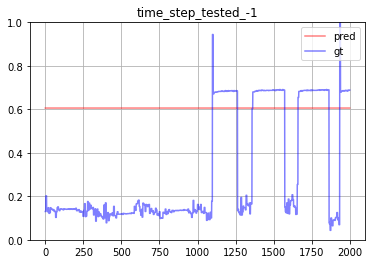

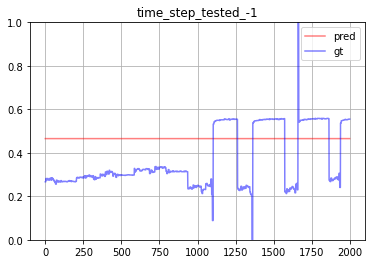

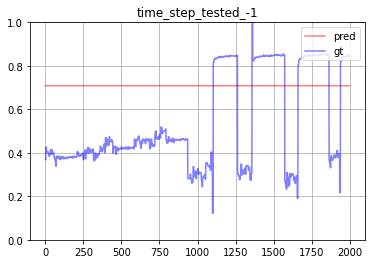

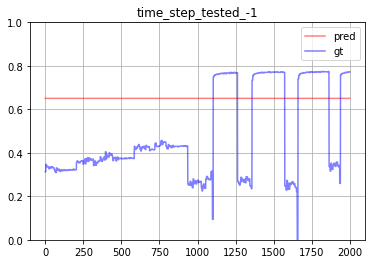

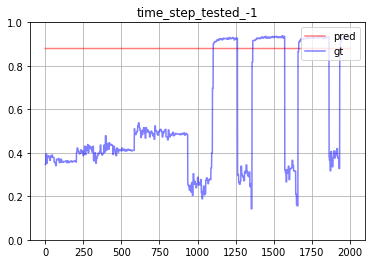

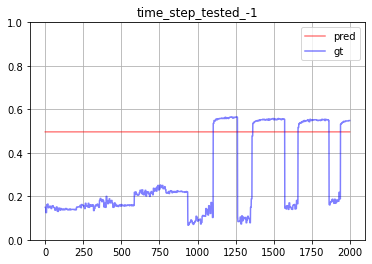

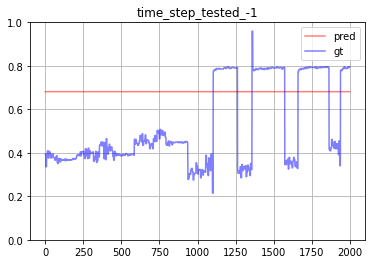

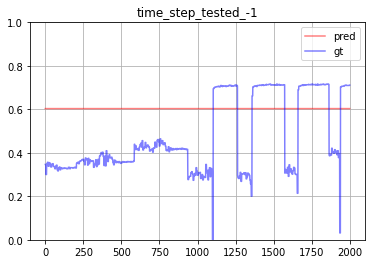

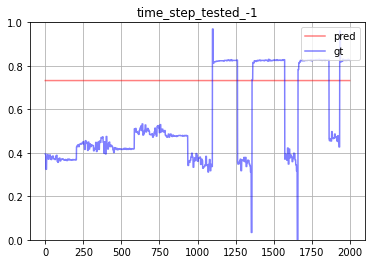

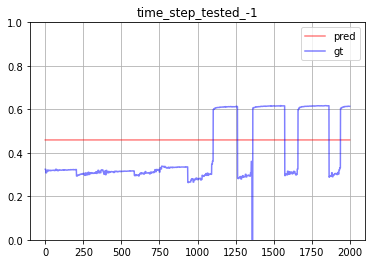

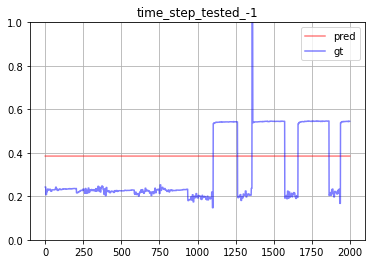

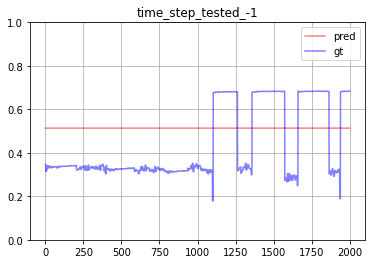

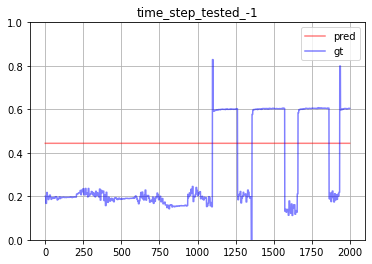

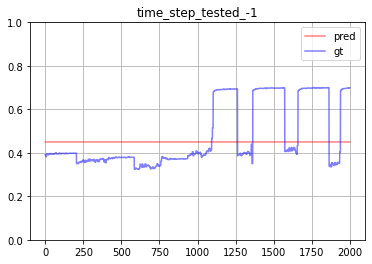

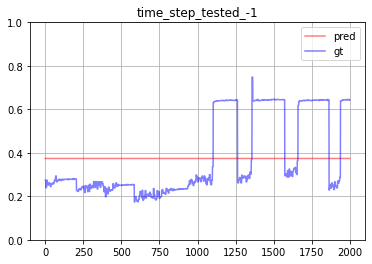

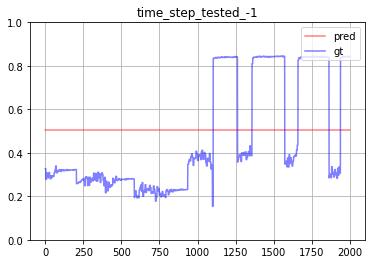

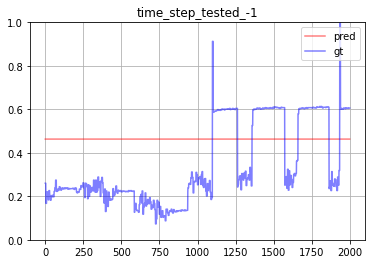

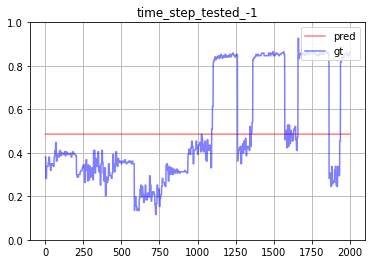

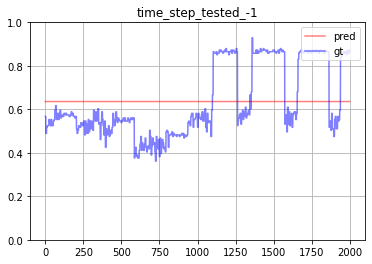

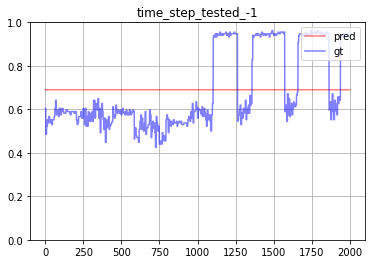

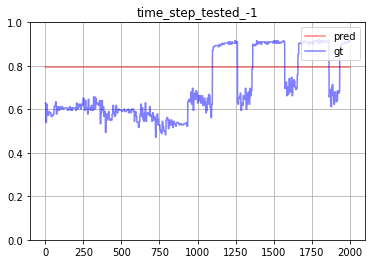

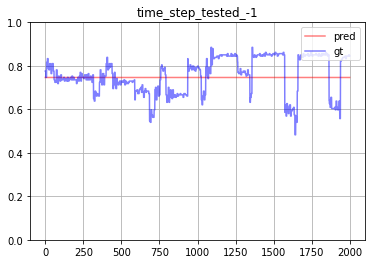

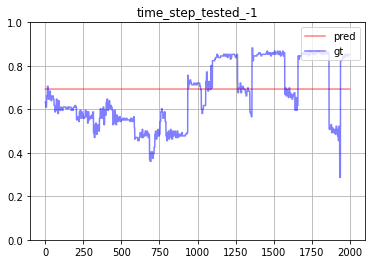

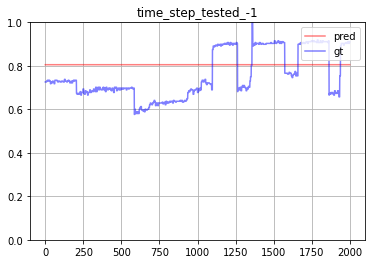

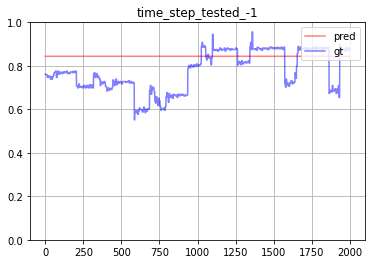

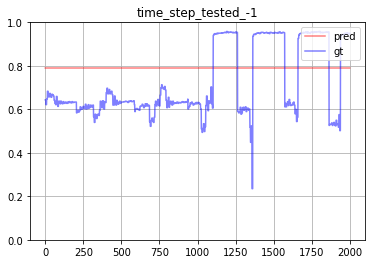

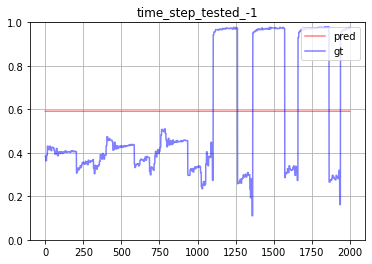

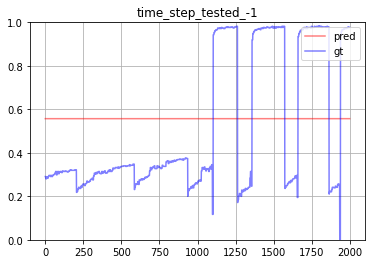

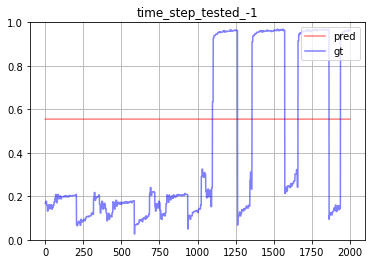

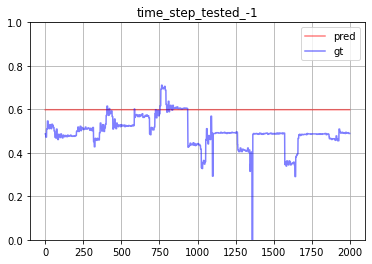

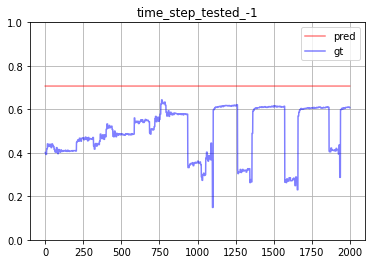

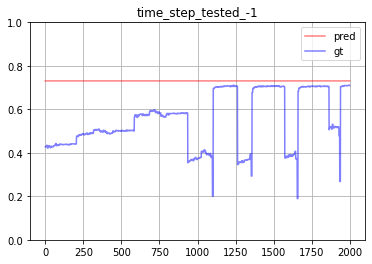

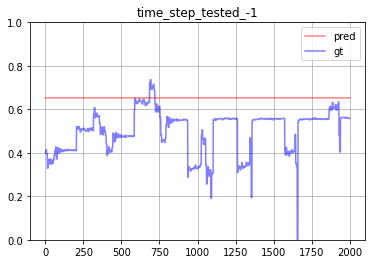

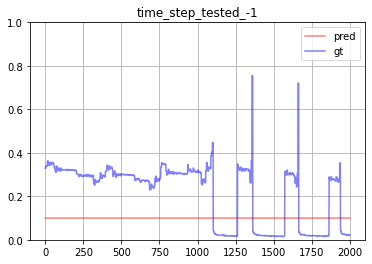

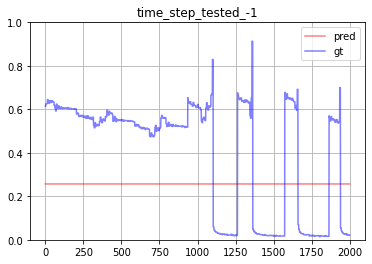

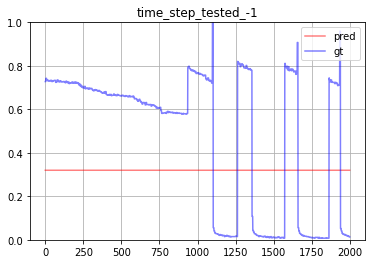

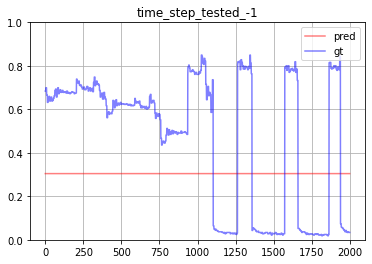

In [41]:
# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
gt = []
taxel = 87

for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t9 = []
        for k in range(2000, 4000):  # len(predicted_data_t1)  # add in length of context data 3000,4000  3100,3300
            data = groundtruth_data[k].cpu().detach().numpy()
            data = data.reshape(int(len(data)/3), 3)
            groundtruth_taxle.append(data.T.flatten()[index])
            data = predicted_data_t1[k].cpu().detach().numpy()
            data = data.reshape(int(len(data)/3), 3)
            predicted_taxel_t1.append(data.T.flatten()[index])
        index += 1
        plt.title("time_step_tested_" + str(time_step_to_test_t1))
        plt.plot(predicted_taxel_t1, alpha=0.5, c="r", label="pred")
        plt.plot(groundtruth_taxle, alpha=0.5, c="b", label="gt")
        plt.ylim([0, 1])
        plt.grid()
        plt.legend(loc="upper right")
#         plt.savefig('/home/user/Robotics/slip_detection_model/images/test_6/simple_model_test_sample_' + str(index) + '.png')
        plt.show()